In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from quaternion2 import Quaternion

In [10]:
# Load data
data_num = 1

imu_data = io.loadmat(f'imu/imuRaw{data_num}.mat')
vicon_data = io.loadmat(f'vicon/viconRot{data_num}.mat')

gyro_raw = np.array(imu_data['vals'])[3:6]
print(gyro_raw)
vicon_rotations = vicon_data['rots']

[[370 369 370 ... 369 369 369]
 [374 373 374 ... 373 374 373]
 [376 376 375 ... 375 376 375]]


In [12]:
gyro = np.array([gyro_raw[1,:], gyro_raw[2,:], gyro_raw[0,:]])

min_length = min(vicon_rotations.shape[2], gyro_raw.shape[1])

vicon_rotations = vicon_rotations[:,:min_length]
gyro = gyro[:,:min_length]

print(gyro)

[[374 373 374 ... 374 374 374]
 [376 376 375 ... 375 376 376]
 [370 369 370 ... 369 370 370]]


In [4]:
qs = [Quaternion()]
for i in range(vicon_rotations.shape[2]):
    qs.append(Quaternion().from_rotm(vicon_rotations[:,:,i]))
qs = np.array(qs)

dif = []
for i in range(1, len(qs)):
    dif.append((qs[i-1].inv() * qs[i]).axis_angle())
dif = np.array(dif)

In [37]:
bias_gyro = np.mean(gyro[:,:10], axis=1)
print(bias_gyro)

sensitivity_gyro = (np.min(gyro.T, axis=0) - bias_gyro)  * 3300/1023 * (np.pi / 180 / np.min(dif, axis=0))
print(sensitivity_gyro)
gyro_adjusted = (gyro.T - bias_gyro)  * 3300/1023 * ((np.pi / 180) / sensitivity_gyro)

[373.6 375.2 369.8]
[344.25212424 348.10054269 272.33317762]


In [38]:
vicon_pos = []
for i in range(vicon_rotations.shape[2]):
    vicon_pos.append(Quaternion().from_rotm(vicon_rotations[:,:,i]).euler_angles())
    
vicon_pos = np.array(vicon_pos)

gyro_pos=[]
cur = Quaternion()  
for i in range(gyro_adjusted.T.shape[1]):
    q = Quaternion().from_axis_angle(gyro_adjusted[i])
    cur *= q
    gyro_pos.append(cur.euler_angles())
    
gyro_pos = np.array(gyro_pos)

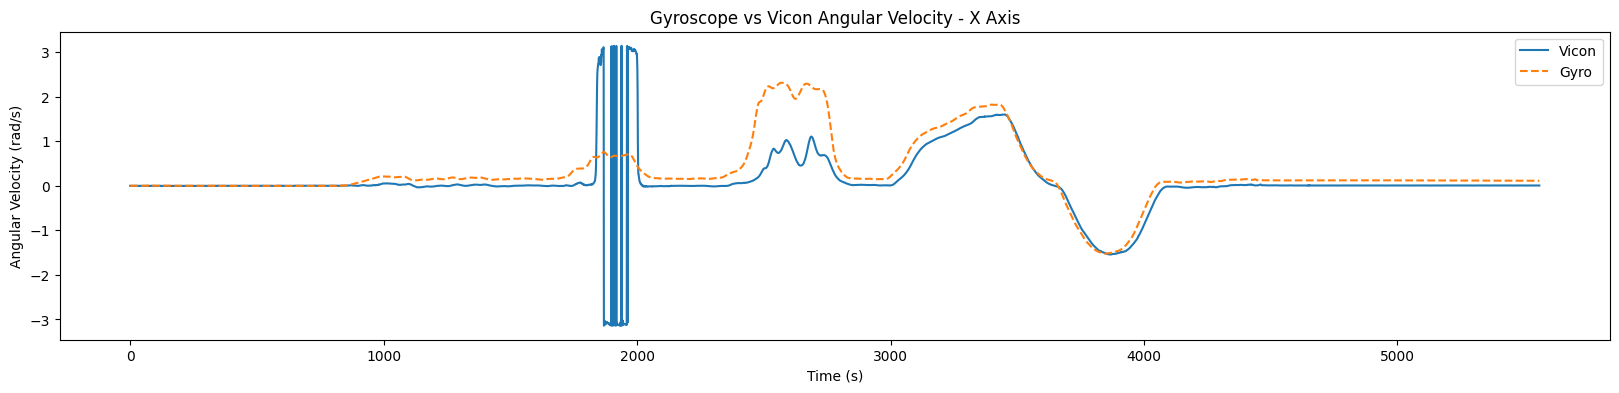

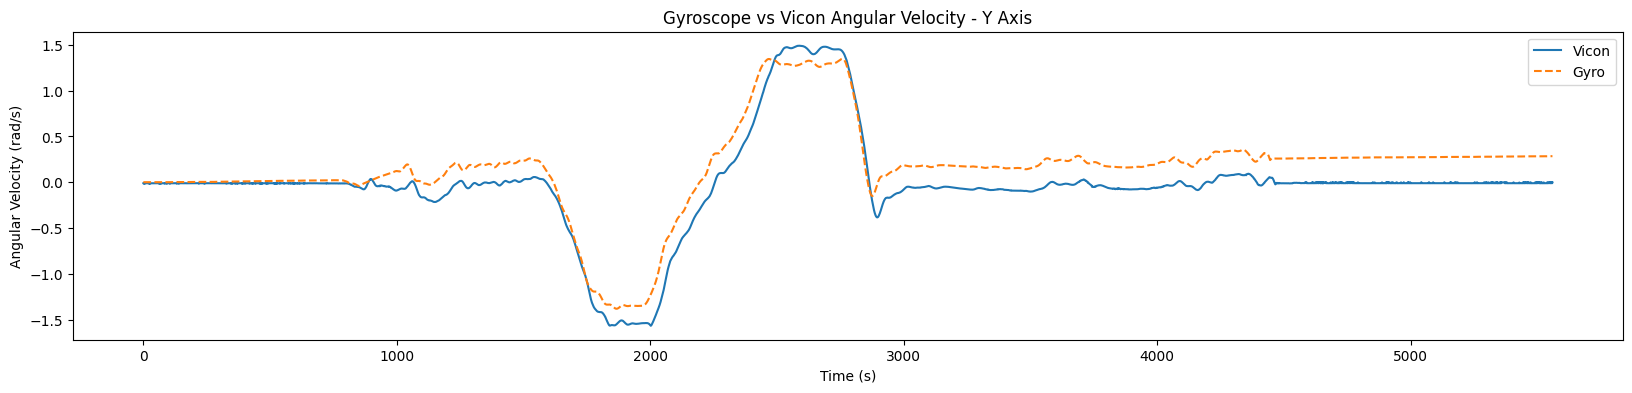

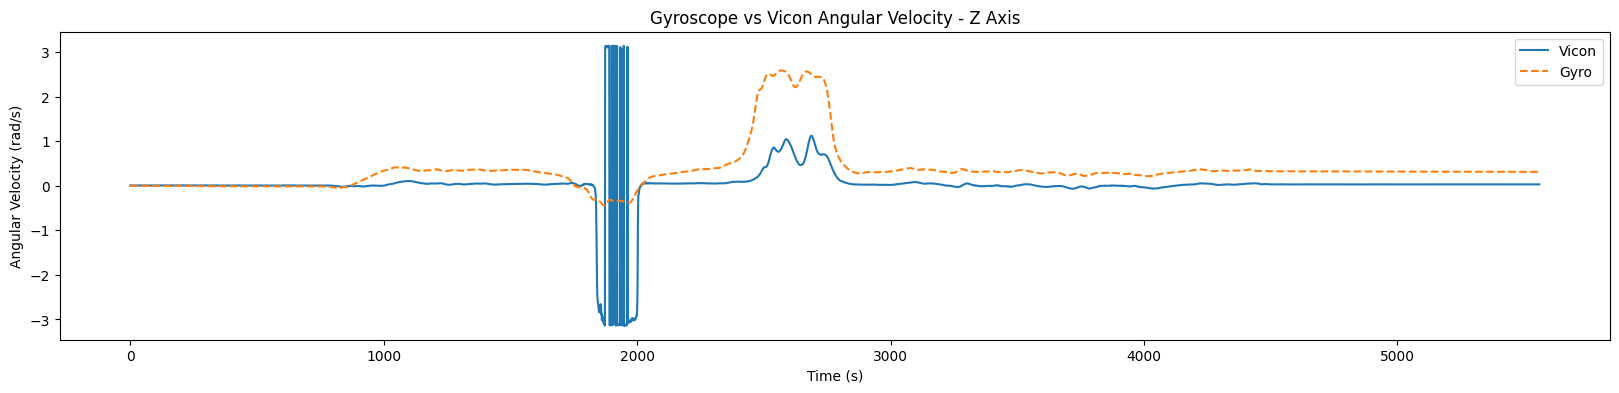

In [39]:
plt.figure(figsize=(20, 4))
plt.plot(vicon_pos.T[0], label='Vicon', linestyle='-')
plt.plot(gyro_pos.T[0], label='Gyro', linestyle='--')
plt.title('Gyroscope vs Vicon Angular Velocity - X Axis')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(vicon_pos.T[1], label='Vicon', linestyle='-')
plt.plot(gyro_pos.T[1], label='Gyro', linestyle='--')
plt.title('Gyroscope vs Vicon Angular Velocity - Y Axis')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(vicon_pos.T[2], label='Vicon', linestyle='-')
plt.plot(gyro_pos.T[2], label='Gyro', linestyle='--')
plt.title('Gyroscope vs Vicon Angular Velocity - Z Axis')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.show()
